In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.convolution import convolve, Box1DKernel

# hdul = fits.open("691108416_c1_e09_hor5_srs.fits")
hdul = fits.open("690059648_c1_e01_hor5_srs.fits")

hdul.info()
print(hdul[0].header)


Filename: 690059648_c1_e01_hor5_srs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (10220,)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    1 / number of array dimensions                     NAXIS1  =                10220                                                  CRVAL1  =                848.2 / value of ref pixel                             CDELT1  =                0.005 / Binning factor                                 CUNIT1  = 'nm      '                                                            BUNIT   = 'adu     '                                                            OBJECT  = '690059648'                                                           RA      =    69.00595833333217                                                  DEC     =   -58.85813888888791   

In [3]:


# fn = "691108416_c1_e09_hor5_srs.fits"
fn = "690059648_c1_e01_hor5_srs.fits"
hdul = fits.open(fn)
flux = hdul[0].data.astype(float)
hdr  = hdul[0].header

crval = hdr["CRVAL1"]   # nm
cdelt = hdr["CDELT1"]   # nm/pix
n     = hdr["NAXIS1"]

wave_nm = crval + cdelt * np.arange(n)
wave_A  = wave_nm * 10.0  # Å

hcorr = hdr.get("HCORR", 0.0)  # km/s


print('heliocentric correction:', hcorr, 'km/s')
print('number of pixels:', n)
print('wavelength step: %.4f nm/pix' % cdelt)
print('starting wavelength: %.1f nm' % wave_nm[0])
print('wavelength range: %.1f - %.1f nm' % (wave_nm[0], wave_nm[-1]))



heliocentric correction: 3.146606982684114 km/s
number of pixels: 10220
wavelength step: 0.0050 nm/pix
starting wavelength: 848.2 nm
wavelength range: 848.2 - 899.3 nm


In [4]:
fn

'690059648_c1_e01_hor5_srs.fits'

HCORR (km/s): 3.146607


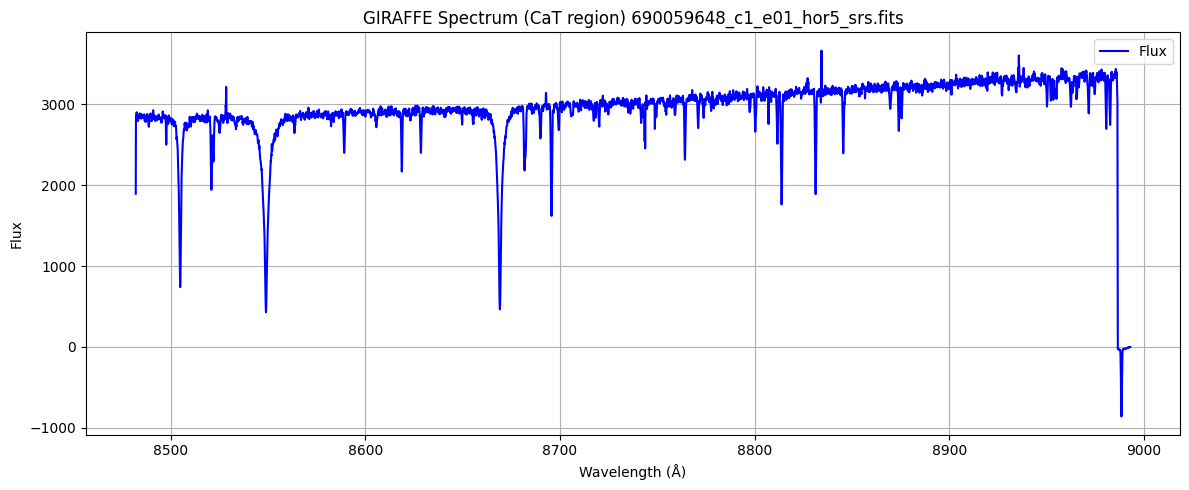

In [5]:

# Optional smoothing (step can be skipped - set boxcar width to 1 to skip)   -    
boxcar_width = 3
flux = convolve(flux, Box1DKernel(boxcar_width))

# heliocentric correction via wavelength shift 
c_kms = 299_792.458
hcorr = float(hdr.get("HCORR", 0.0))  # km/s
wave_A = wave_A * (1.0 + hcorr / c_kms)
print(f"HCORR (km/s): {hcorr:.6f}")

# No error array in this file 
err = None

# Plot spectrum 
plt.figure(figsize=(12, 5))
plt.plot(wave_A, flux, label="Flux", color="blue")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.title(f"GIRAFFE Spectrum (CaT region) {fn}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#  data_store
data_store = {
    "Obs_1": {
        "wavelength": wave_A,
        "flux": flux,
        "error": err,
        "header": hdr,
        "filename": fn
    }
}


In [6]:
data_store

{'Obs_1': {'wavelength': array([8482.08902666, 8482.13902718, 8482.18902771, ..., 8992.94438851,
         8992.99438904, 8993.04438956]),
  'flux': array([1894.13727156, 2838.12326622, 2838.36298974, ...,    0.        ,
            0.        ,    0.        ]),
  'error': None,
  'header': SIMPLE  =                    T / conforms to FITS standard                      
  BITPIX  =                  -64 / array data type                                
  NAXIS   =                    1 / number of array dimensions                     
  NAXIS1  =                10220                                                  
  CRVAL1  =                848.2 / value of ref pixel                             
  CDELT1  =                0.005 / Binning factor                                 
  CUNIT1  = 'nm      '                                                            
  BUNIT   = 'adu     '                                                            
  OBJECT  = '690059648'                         

Synthetic template loaded: synthspec.fits
λ range: 8400.0–8900.0 Å, Npix=10000
min / median / max flux: 0.4708, 0.9980, 0.9999


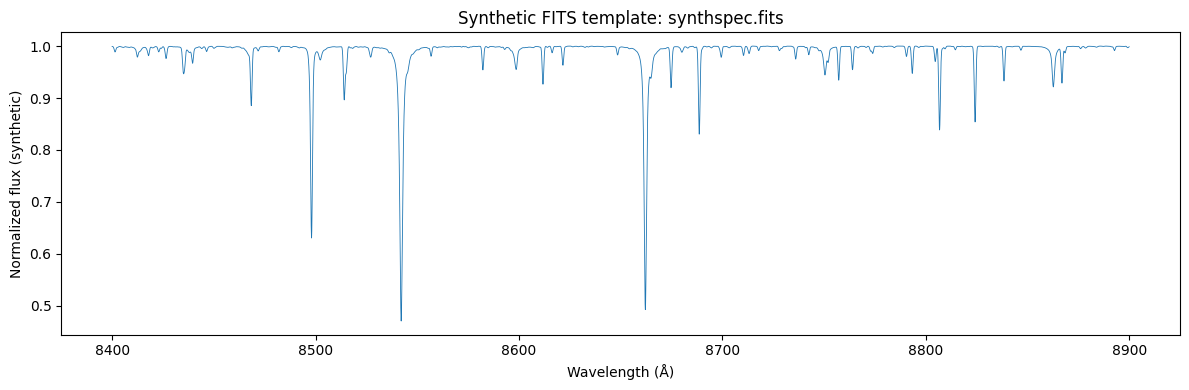

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Define the path to your synthetic FITS file
syn_fits = "synthspec.fits"  

def load_syn_fits(path):
    with fits.open(path) as hdul:
        syn_flux = hdul[0].data.astype(float)
        syn_hdr  = hdul[0].header

    # Build synthetic wavelength grid
    syn_crval = syn_hdr["CRVAL1"]
    syn_cdelt = syn_hdr["CDELT1"]
    syn_npix  = syn_hdr["NAXIS1"]

    syn_wave = syn_crval + syn_cdelt * np.arange(syn_npix)

    # Handle wavelength units safely
    syn_cunit = syn_hdr.get("CUNIT1", "").strip().lower()
    syn_wave = syn_wave * 10.0   # nm → Å

    # Normalise synthetic if needed
    syn_flux_norm = syn_flux.copy()
    med = np.nanmedian(syn_flux_norm)
    if med > 1.5:   # heuristic: absolute flux → normalize
        syn_flux_norm /= med

    return syn_wave, syn_flux_norm, syn_hdr


syn_wave, syn_flux_norm, syn_hdr = load_syn_fits(syn_fits)

print(f"Synthetic template loaded: {syn_fits}")
print(f"λ range: {syn_wave[0]:.1f}–{syn_wave[-1]:.1f} Å, Npix={syn_wave.size}")
print(f"min / median / max flux: "
      f"{syn_flux_norm.min():.4f}, "
      f"{np.median(syn_flux_norm):.4f}, "
      f"{syn_flux_norm.max():.4f}")


plt.figure(figsize=(12,4))
plt.plot(syn_wave, syn_flux_norm, lw=0.6)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Normalized flux (synthetic)")
plt.title(f"Synthetic FITS template: {syn_fits}")
plt.tight_layout()
plt.show()

syn_store = {
    "Template_1": {
        "wavelength": syn_wave,
        "flux": syn_flux_norm,
        "header": syn_hdr,
        "filename": syn_fits
    }
}




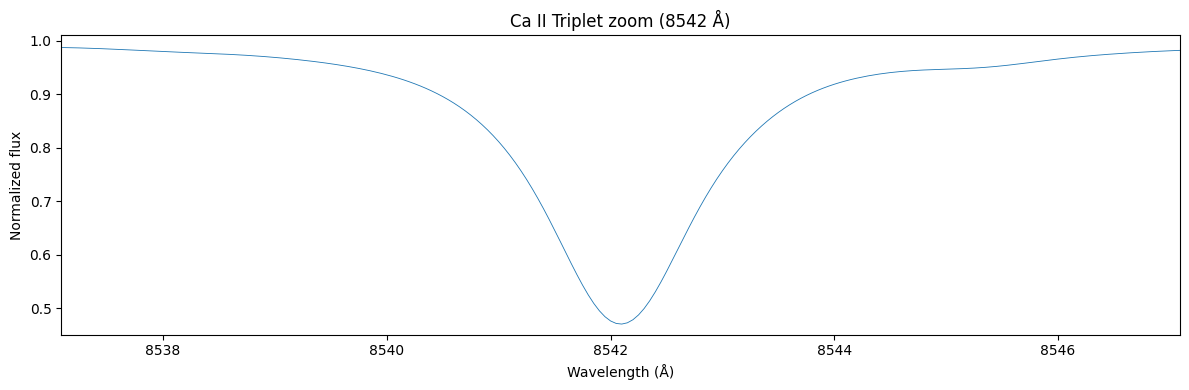

: 

: 

: 

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(syn_wave, syn_flux_norm, lw=0.6)
w0 = 8542.09  # CaT line
mask = (syn_wave > w0-5) & (syn_wave < w0+5)
plt.xlim(w0-5, w0+5)
plt.ylim(syn_flux_norm[mask].min() - 0.02, 1.01)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Normalized flux")
plt.title("Ca II Triplet zoom (8542 Å)")
plt.tight_layout()
plt.show()



In [ ]:
# THIS IS FOR TAKEING IN K2 .SYN FILES  - note issue above 8000 A region...??
# import numpy as np
# import matplotlib.pyplot as plt

# # --- set your template path here ---
# # syn_path = "am057t5030g200k120_cl_ap04_8000_9200_R20000.syn"   # <-- change to your actual .syn file
# # syn_path = "am165t5500g200k120_cl_ap02_8400_9050_R18000.syn"   # <-- change to your actual .syn file"   # <-- change to your actual .syn file
# syn_path = "am170t5257g319k050_cl_ap04_5000_9000_R18000.syn"   # <-- change to your actual .syn file

# # syn_path = "am170t6183g405k200_cl_ap04_4500_7000_R40000.syn"   # STAR 2<-- change to your actual .syn file   
# #    am220 = [M/H] –2.20; t5507 = Teff 5507 K; g346 = log g 3.46 (cgs); k200 = microturbulence 2.0 km/s; cl = classical ATLAS9 convection; ap04 = [α/Fe] +0.4; 4500_7000 = wavelength range 4500–7000 Å; R40000 = resolving power λ/Δλ = 40,000

# # Flexible loader for K2 .syn (handles 2- or 4-column variants)
# def load_k2_syn(path):
#     arr = np.genfromtxt(path, comments='#')
#     lam = arr[:, 0]
#     if arr.shape[1] >= 2:
#         fnorm = arr[:, 1]              # NORM. FLUX (preferred)
#     else:
#         raise ValueError("Template missing normalized column.")
#     # sanity check; if it's not ~flat around 1, recompute from line/cont if present
#     med = np.nanmedian(fnorm)
#     if not (0.9 < med < 1.1) and arr.shape[1] >= 4:
#         fnorm = arr[:, 1] / arr[:, 3]  # LINE/CONT fallback    -   NORMALISE by dividing line by cont (column 1 / column 3)
#     return lam, fnorm

# lam_t, fnorm_t = load_k2_syn(syn_path)  # this line calls the function above and runs it with the syn_path set above

# print(f"Template loaded: {syn_path}")
# print(f"λ range: {lam_t[0]:.1f}–{lam_t[-1]:.1f} Å, Npix={lam_t.size}")

# # Quick look
# plt.figure(figsize=(12,4))
# plt.plot(lam_t, fnorm_t, lw=0.6)    #  lambda (wavelength) form the synthetic spectrum  and  fnorm (normalized flux)  from the synthetic spectra
# plt.xlabel("Wavelength (Å)"); plt.ylabel("Normalized flux (template)")
# plt.title(f"K2 synthetic:   {syn_path}")
# plt.tight_layout()
# plt.xlim(lam_t[0], lam_t[-1])
# # plt.ylim(0.9999, 1.00001)
# # plt.xlim(8535, 8545)
# plt.show()


: 

: 

: 

: 

: 

: 

: 

: 

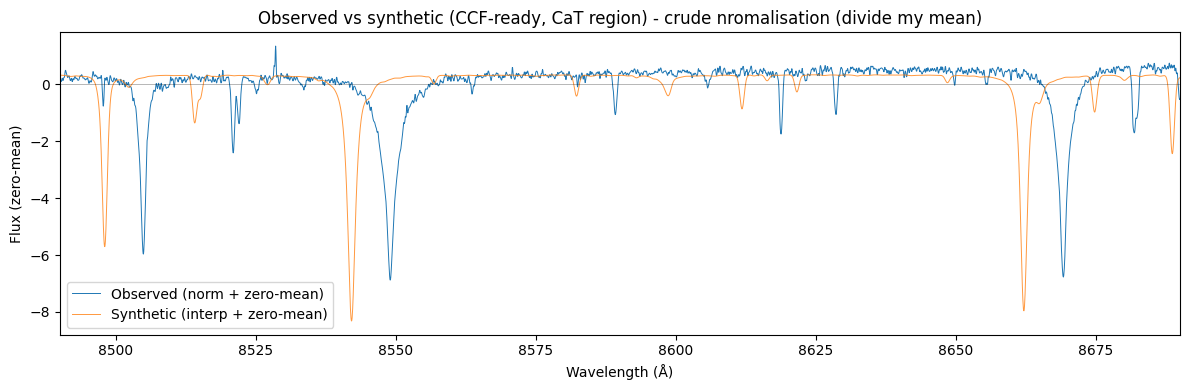

In [8]:
#  prepare synthetic and obs spectra for convolution (1)  (simple /mean for the normalised observed):    normalise observed spectra   aND     Interpolate synthetic onto observed grid

import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel

# --------------------------------------------------
# Wavelength window (CaT region)
# --------------------------------------------------
wmin, wmax = 8490.0, 8690.0

# --------------------------------------------------
# Observed spectrum (from data_store)
# --------------------------------------------------
obs = data_store["Obs_1"]
wave_o = obs["wavelength"]
flux_o_full = obs["flux"].astype(float)

m_obs = (wave_o >= wmin) & (wave_o <= wmax)   #  mask BETWEEN wmin and wmax
lam_o  = wave_o[m_obs].copy()                 #  observed wavelength array within window - BETWEEN wmin and wmax
flux_o = flux_o_full[m_obs].copy()           #  observed flux array within window - BETWEEN wmin and wmax
fnorm_o = flux_o/np.median(flux_o)            # normalise observed spectrum here

# --------------------------------------------------
# Synthetic spectrum (from syn_store)
# --------------------------------------------------
syn = syn_store["Template_1"]
wave_s = syn["wavelength"]
flux_s_full = syn["flux"]

m_syn = (wave_s >= wmin) & (wave_s <= wmax)
lam_s  = wave_s[m_syn]
flux_s = flux_s_full[m_syn]

# Interpolate synthetic onto observed grid
syn_on_obs = np.interp(lam_o, lam_s, flux_s, left=np.nan, right=np.nan)


# --------------------------------------------------
# Remove mean level -  best practice to prepare for CCF  (so you will be cross-correlating zero-mean functions)
# --------------------------------------------------
obs_ccf = (fnorm_o     - np.nanmean(fnorm_o))     / np.nanstd(fnorm_o)
syn_ccf = (syn_on_obs  - np.nanmean(syn_on_obs))  / np.nanstd(syn_on_obs)

# obs_ccf = fnorm_o
# syn_ccf = syn_on_obs

# --------------------------------------------------
# Sanity-check plot (CCF-ready spectra)
# --------------------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(lam_o, obs_ccf, lw=0.7, label="Observed (norm + zero-mean)")
plt.plot(lam_o, syn_ccf, lw=0.7, alpha=0.8, label="Synthetic (interp + zero-mean)")
plt.axhline(0.0, color="k", lw=0.5, alpha=0.4)

plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (zero-mean)")
plt.title("Observed vs synthetic (CCF-ready, CaT region) - crude nromalisation (divide my mean)")
plt.xlim(wmin, wmax)
plt.legend()
plt.tight_layout()
plt.show()


note  method (1) just divides by mena so you can see above the fluctuation in the continuum of the observed

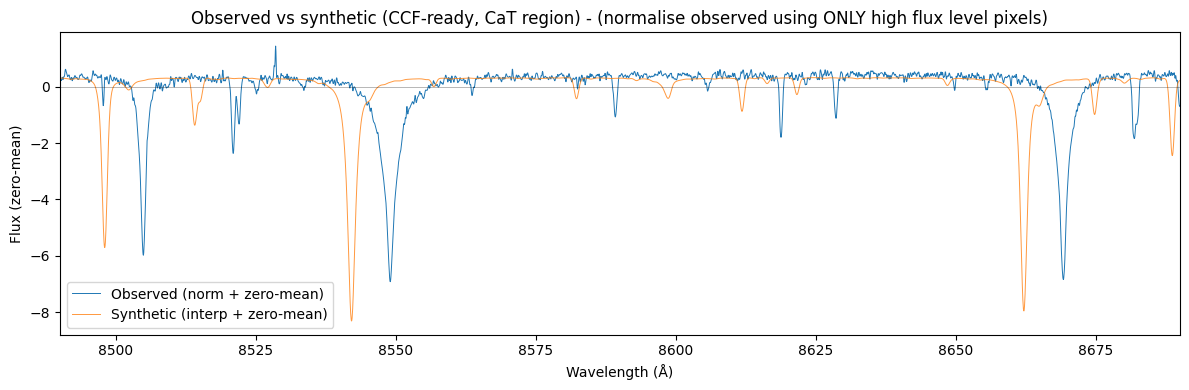

In [9]:
#  prepare synthetic and obs spectra for convolution (2)  (nromalise observed using ONLY high flux level pixels):    normalise observed spectra   aND     Interpolate synthetic onto observed grid

import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel

# --------------------------------------------------
# Wavelength window (CaT region)
# --------------------------------------------------
wmin, wmax = 8490.0, 8690.0

# --------------------------------------------------
# Observed spectrum (from data_store)
# --------------------------------------------------
obs = data_store["Obs_1"]
wave_o = obs["wavelength"]
flux_o_full = obs["flux"].astype(float)

m_obs = (wave_o >= wmin) & (wave_o <= wmax)   #  mask BETWEEN wmin and wmax
lam_o  = wave_o[m_obs].copy()                 #  observed wavelength array within window - BETWEEN wmin and wmax
flux_o = flux_o_full[m_obs].copy()           #  observed flux array within window - BETWEEN wmin and wmax
flux_o = flux_o/np.median(flux_o)            # normalise observed spectrum here

# --------------------------------------------------
# Global continuum normalization (polynomial fit)

# Identify "continuum-like" pixels: keep the top part of the flux distribution
# (tweak 70–90 depending on how line-crowded your star is)
q = 40  # percentile used as a continuum selector    -  ie KEEP pixels above this flux level  so if q=40, keep pixels above 40th percentile flux value (so keep the top 60% of flux values)
thr = np.nanpercentile(flux_o, q)

cont_mask = flux_o > thr

# (Optional) also exclude a small window around the three CaT line centers
cat_lines = np.array([8498.02, 8542.09, 8662.14])
mask_cat = np.ones_like(lam_o, dtype=bool)
for lc in cat_lines:
    mask_cat &= ~((lam_o > lc - 4.0) & (lam_o < lc + 4.0))  # +/- 4 Å

cont_mask &= mask_cat

# Fit a low-order polynomial continuum to those pixels
deg = 2
p = np.polyfit(lam_o[cont_mask], flux_o[cont_mask], deg=deg)
cont_fit = np.polyval(p, lam_o)

# Divide out the smooth continuum
fnorm_o = flux_o / cont_fit




# # --------------------------------------------------
# # Pseudo-continuum + normalization (local window)
# # --------------------------------------------------
# box = Box1DKernel(101)

# cont_o = convolve(np.clip(flux_o, np.percentile(flux_o, 0.5), None), box, boundary="extend")
# cont_o[cont_o <= 0] = np.nanmedian(cont_o[cont_o > 0])

# fnorm_o = flux_o / cont_o   # continuum ≈ 1

# --------------------------------------------------
# Synthetic spectrum (from syn_store)
# --------------------------------------------------
syn = syn_store["Template_1"]
wave_s = syn["wavelength"]
flux_s_full = syn["flux"]

m_syn = (wave_s >= wmin) & (wave_s <= wmax)
lam_s  = wave_s[m_syn]
flux_s = flux_s_full[m_syn]

# Interpolate synthetic onto observed grid
syn_on_obs = np.interp(lam_o, lam_s, flux_s, left=np.nan, right=np.nan)


# --------------------------------------------------
# Remove mean level -  best practice to prepare for CCF  (so you will be cross-correlating zero-mean functions)
# --------------------------------------------------
obs_ccf = (fnorm_o     - np.nanmean(fnorm_o))     / np.nanstd(fnorm_o)
syn_ccf = (syn_on_obs  - np.nanmean(syn_on_obs))  / np.nanstd(syn_on_obs)

# obs_ccf = fnorm_o
# syn_ccf = syn_on_obs

# --------------------------------------------------
# Sanity-check plot (CCF-ready spectra)
# --------------------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(lam_o, obs_ccf, lw=0.7, label="Observed (norm + zero-mean)")
plt.plot(lam_o, syn_ccf, lw=0.7, alpha=0.8, label="Synthetic (interp + zero-mean)")
plt.axhline(0.0, color="k", lw=0.5, alpha=0.4)

plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (zero-mean)")
plt.title("Observed vs synthetic (CCF-ready, CaT region) - (normalise observed using ONLY high flux level pixels)")
plt.xlim(wmin, wmax)
plt.legend()
plt.tight_layout()
plt.show()


Continuum-window noise estimates (fnorm_o):
   8512.0- 8519.0 Å : sigma= 0.00950   N=140
   8565.0- 8575.0 Å : sigma= 0.00781   N=198
   8608.0- 8615.0 Å : sigma= 0.01071   N=140
   8635.0- 8648.0 Å : sigma= 0.00852   N=257

Adopted sigma_flux (median over windows) = 0.00901
Approx continuum SNR per pixel ~ 111.0


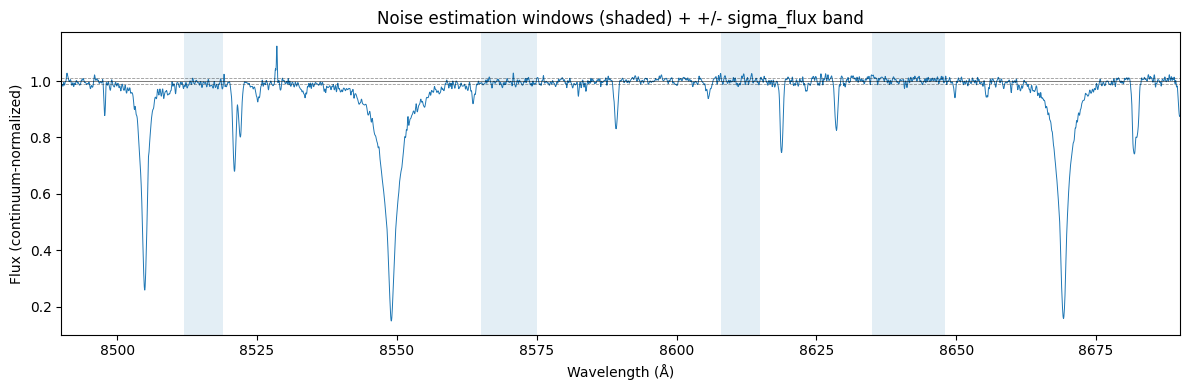

In [10]:
# --------------------------------------------------
# Estimate per-spectrum noise (flux sigma)
# (auto, robust; uses several small continuum windows + MAD + sigma-clipping)
# --------------------------------------------------

def robust_sigma_mad(x):
    """Robust 1-sigma estimate from MAD (works well for non-Gaussian tails)."""
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if x.size < 10:
        return np.nan
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    return 1.4826 * mad

def sigma_clip_mask(y, nsig=3.0, iters=5):
    """Return mask of points kept after iterative sigma clipping."""
    y = np.asarray(y)
    m = np.isfinite(y)
    if m.sum() < 10:
        return m
    for _ in range(iters):
        yy = y[m]
        mu = np.nanmedian(yy)
        sig = robust_sigma_mad(yy)
        if not np.isfinite(sig) or sig <= 0:
            break
        m = m & (np.abs(y - mu) <= nsig * sig)
        if m.sum() < 10:
            break
    return m

# Choose whether noise should reflect the spectrum used for the CCF.
# If your CCF uses obs_ccf (zero-mean, standardized), noise there is ~1 by construction,
# so instead estimate noise on fnorm_o (continuum-normalized flux around ~1).
# That's the meaningful "flux noise" for an error floor.
flux_for_noise = fnorm_o  # continuum-normalized, NOT standardized

# Define small continuum-ish windows in the CaT range (Å)
# (Keep them away from the three CaT lines and common strong features.)
cont_windows = [
    (8512.0, 8519.0),
    (8565.0, 8575.0),
    (8608.0, 8615.0),
    (8635.0, 8648.0),
]

sigmas = []
npixs  = []

for (a, b) in cont_windows:
    mw = (lam_o >= a) & (lam_o <= b) & np.isfinite(flux_for_noise)
    if mw.sum() < 20:
        sigmas.append(np.nan)
        npixs.append(mw.sum())
        continue

    y = flux_for_noise[mw]
    keep = sigma_clip_mask(y, nsig=3.0, iters=5)
    sig = robust_sigma_mad(y[keep])

    sigmas.append(sig)
    npixs.append(int(keep.sum()))

sigma_flux = np.nanmedian(sigmas)

# Optional: convert to an approximate SNR per pixel in continuum-normalized units
# (since continuum is ~1, SNR ~ 1/sigma)
snr_pix = (1.0 / sigma_flux) if np.isfinite(sigma_flux) and sigma_flux > 0 else np.nan

print("Continuum-window noise estimates (fnorm_o):")
for (w, sig, n) in zip(cont_windows, sigmas, npixs):
    print(f"  {w[0]:7.1f}-{w[1]:7.1f} Å : sigma={sig:8.5f}   N={n}")

print(f"\nAdopted sigma_flux (median over windows) = {sigma_flux:.5f}")
print(f"Approx continuum SNR per pixel ~ {snr_pix:.1f}")

# Quick plot showing where noise windows are and a +/-1sigma band around continuum=1
plt.figure(figsize=(12, 4))
plt.plot(lam_o, fnorm_o, lw=0.7, label="Observed fnorm_o (continuum-normalized)")
for (a, b) in cont_windows:
    plt.axvspan(a, b, alpha=0.12)
if np.isfinite(sigma_flux):
    plt.axhline(1.0, lw=0.6, alpha=0.6, color="k")
    plt.axhline(1.0 + sigma_flux, lw=0.6, alpha=0.4, color="k", linestyle="--")
    plt.axhline(1.0 - sigma_flux, lw=0.6, alpha=0.4, color="k", linestyle="--")

plt.xlim(wmin, wmax)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (continuum-normalized)")
plt.title("Noise estimation windows (shaded) + +/- sigma_flux band")
plt.tight_layout()
plt.show()


Peak RV = 242.18 km/s | rvstep ≈ 1.75 km/s | N=3542 | skipedge=35


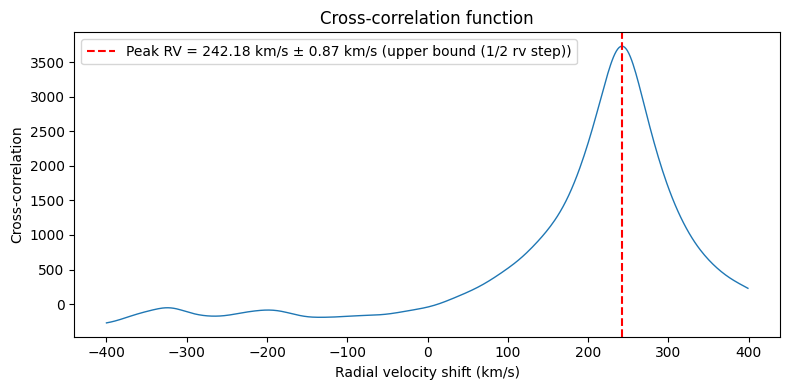

In [11]:
from PyAstronomy import pyasl
import numpy as np
import matplotlib.pyplot as plt

c_kms = 299_792.458
rv_half_range = 400  # km/s
rvmin, rvmax = -rv_half_range, rv_half_range

# --------------------------------------------------
# Observed CCF-ready arrays from previous cell
# (lam_o, obs_ccf)
# --------------------------------------------------
w_obs = np.asarray(lam_o, dtype=float)
f_obs = np.asarray(obs_ccf, dtype=float)

obs_mask = np.isfinite(w_obs) & np.isfinite(f_obs)
w_obs = w_obs[obs_mask]
f_obs = f_obs[obs_mask]

# ensure increasing wavelength
if w_obs[0] > w_obs[-1]:
    w_obs = w_obs[::-1]
    f_obs = f_obs[::-1]

# --------------------------------------------------
# Template from syn_store (native grid; DO NOT interp here)
# --------------------------------------------------
syn = syn_store["Template_1"]
w_tpl = np.asarray(syn["wavelength"], dtype=float)
f_tpl = np.asarray(syn["flux"], dtype=float)

tpl_mask = np.isfinite(w_tpl) & np.isfinite(f_tpl)
w_tpl = w_tpl[tpl_mask]
f_tpl = f_tpl[tpl_mask]

if w_tpl[0] > w_tpl[-1]:
    w_tpl = w_tpl[::-1]
    f_tpl = f_tpl[::-1]

# Restrict template to the same wavelength window used for obs
# (uses the same wmin/wmax you set in the prep cell)
m_tpl_win = (w_tpl >= wmin) & (w_tpl <= wmax)
w_tpl = w_tpl[m_tpl_win]
f_tpl = f_tpl[m_tpl_win]

# Standardize template for CCF (obs is already standardized)
f_tpl = (f_tpl - np.nanmean(f_tpl)) / (np.nanstd(f_tpl, ddof=0) or 1.0)

# --------------------------------------------------
# Trim observed to RV-safe overlap region
# (so shifting by rvmin/rvmax stays inside template coverage)
# --------------------------------------------------
low_bound  = max(w_obs.min(), w_tpl.min() * (1.0 + rvmax / c_kms))
high_bound = min(w_obs.max(), w_tpl.max() * (1.0 + rvmin / c_kms))
keep = (w_obs >= low_bound) & (w_obs <= high_bound)
w_obs = w_obs[keep]
f_obs = f_obs[keep]

# --------------------------------------------------
# Choose RV step from observed pixel scale
# --------------------------------------------------
dlam = np.median(np.diff(w_obs))
rvstep = dlam * c_kms / np.median(w_obs)
max_error = rvstep / 2.0

# skipedge: trim edges to reduce interpolation edge effects
safe_skip = max(0, min(len(w_obs)//100, 50))

# --------------------------------------------------
# Cross-correlation
# --------------------------------------------------
RV, CC = pyasl.crosscorrRV(
    w_obs, f_obs,
    w_tpl, f_tpl,
    rvmin, rvmax, rvstep,
    skipedge=safe_skip
)

peak_index = np.argmax(CC)
best_rv = RV[peak_index]
print(f"Peak RV = {best_rv:.2f} km/s | rvstep ≈ {rvstep:.2f} km/s | N={len(w_obs)} | skipedge={safe_skip}")

plt.figure(figsize=(8,4))
plt.plot(RV, CC, lw=1)
plt.axvline(best_rv, color="r", ls="--", label=f"Peak RV = {best_rv:.2f} km/s ± {max_error:.2f} km/s (upper bound (1/2 rv step))")
plt.xlabel("Radial velocity shift (km/s)")
plt.ylabel("Cross-correlation")
plt.title("Cross-correlation function")
plt.legend()
plt.tight_layout()
plt.show()



the error:  1/2 of the rV step is  the quantization limit if you did no interpolation of the CCF peak

its a very conservative upper bound

you can easily measure RVs to much better than one pixel.

so fit a parabola or Gaussian to the top few points of the CCF --- get sub-pixel precision

RV (grid-peak): 242.180 km/s   (limited by rvstep=1.745 km/s)
RV (Gaussian fit): 241.740 ± 0.066 km/s
CCF FWHM: 66.60 ± 0.84 km/s - describes shape of CCF peak (specifically its full-width-at-half-maximum) - reflecing widths of lines in spectra
Tonry–Davis R: 2.42   (higher is better)
RV (Tonry–Davis error): ± 7.294 km/s


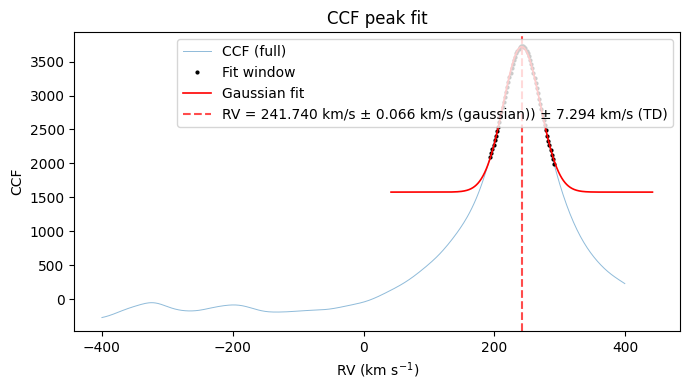

In [12]:
# --- Gaussian fit of the CCF peak for sub-grid RV ---

from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

def gaussian(x, amp, mu, fwhm, off):
    # convert FWHM <-> sigma: FWHM = 2*sqrt(2*ln2)*sigma
    sigma = fwhm / (2*np.sqrt(2*np.log(2)))
    return amp * np.exp(-(x-mu)**2/(2*sigma**2)) + off

# 1) pick a window around the grid peak
i0   = np.argmax(CC)
mu0  = RV[i0]   # grid peak RV, as a first guess for guassian fit centre    [does the same as (best_rv = RV[peak_index]) line in above cell]

# choose a reasonable initial width for the CCF peak
# (CaT at R~18000 often gives a CCF peak width of order ~20–40 km/s, but this is just for the initial fit window)
guess_fwhm = 50.0  # km/s, adjust if needed
win  = guess_fwhm
sel  = (RV > mu0 - win) & (RV < mu0 + win)

x = RV[sel]
y = CC[sel]

# 2) initial guess and bounds
p0 = [y.max() - np.median(y), mu0, max(5.0, guess_fwhm), np.median(y)]
bounds = ([0, mu0-2*win, 1.0, -np.inf],
          [np.inf, mu0+2*win, 200.0,  np.inf])

# 3) fit
popt, pcov = curve_fit(gaussian, x, y, p0=p0, bounds=bounds, maxfev=20000)    #  pcov = estimated covariance matrix of those parameters
amp, mu_fit, fwhm_fit, off = popt                                      # fitted parameters from the gaussian fit


# --- Tonry–Davis (1979) error on RV (uses fitted FWHM and antisymmetric CCF noise) ---
fwhm_kms = float(fwhm_fit)   # fitted FWHM of correlation peak in km/s                                                         -  broader peak is a worse RV precision
amp_peak = max(float(amp), 0.0)    #  fitted Gaussian amplitude of the CCF peak                                               - this is the signal strength of the correlation peak

# antisymmetric CCF noise; exclude a region around the peak
# IMPORTANT: CC[::-1] is only valid if RV is symmetric/evenly sampled about 0. Safer to build an antisymmetric component via interpolation.
win_antisym = max(2.0 * fwhm_kms, 20.0)  # km/s                              -    Defines  vel window around the CCF peak that will be excluded when measuring noise -  BUT it will never be less than 20 km/s

# Build antisymmetric component A(v) = 0.5 [CC(v) - CC(-v)] on a symmetric RV grid
RV = np.asarray(RV, dtype=float)
CC = np.asarray(CC, dtype=float)

# Use only finite values and ensure RV is increasing
mfin = np.isfinite(RV) & np.isfinite(CC)
rvv = RV[mfin]
ccv = CC[mfin]
if rvv[0] > rvv[-1]:
    rvv = rvv[::-1]
    ccv = ccv[::-1]

# Symmetric RV grid around 0 for antisymmetry calculation
rv_sym = np.linspace(-min(abs(rvv.min()), abs(rvv.max())),
                      min(abs(rvv.min()), abs(rvv.max())),
                      rvv.size)

cc_pos = np.interp(rv_sym, rvv, ccv, left=np.nan, right=np.nan)
cc_neg = np.interp(-rv_sym, rvv, ccv, left=np.nan, right=np.nan)

resid_antisym = 0.5 * (cc_pos - cc_neg)                 #  Compute antisymmetric component of the CCF

# Noise mask: away from the fitted peak (use mu_fit, not mu0)
mask_noise = (rv_sym < mu_fit - win_antisym) | (rv_sym > mu_fit + win_antisym)     #  Mask to select noise regions away from the peak

if np.isfinite(resid_antisym).sum() < 10:
    sigma_a = np.nan
else:
    sigma_a = (np.nanstd(resid_antisym[mask_noise])
               if np.isfinite(resid_antisym[mask_noise]).sum() > 10 else np.nanstd(resid_antisym))

if (sigma_a is not None) and np.isfinite(sigma_a) and (sigma_a > 0):
    TD_R = amp_peak / (np.sqrt(2.0) * sigma_a)
    RV_td_err_kms = (3.0/8.0) * fwhm_kms / (1.0 + TD_R)
else:
    TD_R = np.nan
    RV_td_err_kms = np.nan
# --- end Tonry–Davis block ---


# 4) 1-sigma errors from covariance (approximate)
perr = np.sqrt(np.diag(pcov)) if np.all(np.isfinite(pcov)) else [np.nan]*4     #   perr = np.sqrt(np.diag(pcov))..   pcov is the covariance matrix returned by scipy.optimize.curve_fit   -    np.diag(pcov) extracts the variances of each fitted parameter.
amp_err, mu_err, fwhm_err, off_err = perr                                      #   mu_err is the 1σ uncertainty on the fitted Gaussian center mu_fit

# 5) report
print(f"RV (grid-peak): {mu0:.3f} km/s   (limited by rvstep={rvstep:.3f} km/s)")
print(f"RV (Gaussian fit): {mu_fit:.3f} ± {mu_err:.3f} km/s")
print(f"CCF FWHM: {fwhm_fit:.2f} ± {fwhm_err:.2f} km/s - describes shape of CCF peak (specifically its full-width-at-half-maximum) - reflecing widths of lines in spectra")
print(f"Tonry–Davis R: {TD_R:.2f}   (higher is better)")
print(f"RV (Tonry–Davis error): ± {RV_td_err_kms:.3f} km/s")

# 6) plot zoom with fit
xx = np.linspace(mu_fit - 3*fwhm_kms, mu_fit + 3*fwhm_kms, 800)
plt.figure(figsize=(7,4))
plt.plot(RV, CC, lw=0.7, alpha=0.5, label="CCF (full)")
plt.plot(x, y, 'k.', ms=4, label="Fit window")
plt.plot(xx, gaussian(xx, *popt), 'r-', lw=1.2, label="Gaussian fit")
plt.axvline(mu_fit, color='r', ls='--', alpha=0.7, label=f"RV = {mu_fit:.3f} km/s ± {mu_err:.3f} km/s (gaussian)) ± {RV_td_err_kms:.3f} km/s (TD)")
plt.xlabel("RV (km s$^{-1}$)"); plt.ylabel("CCF")
plt.title(f"CCF peak fit")
plt.legend(); plt.tight_layout(); plt.show()



Tonry & Davis (1979)-style uncertainty estimate based on:

1) the width of the CCF peak (the fitted FWHM),

2) the peak height (fitted amplitude),

3) and an estimate of the antisymmetric noise in the CCF.

FWHM of th CORRELATION PEAK tells you how broad the correlation peak is, which reflects: intrinsic line widths in the spectra, instrumental resolution, rotational broadening, template mismatch effects
fwhm_err is not a measure of how well you know the RV — you can have a large FWHM but still measure the centre very precisely (if the S/N is high).

In [ ]:
# Tonry–Davis error is very large for large SNR spectra
#  because (1) it guesses the noise from antisymmetric part of CCF, (which is very small for high SNR data)  -  so here we calculate the noise ourselves from the spectrum


: 

: 

: 

: 

OUR NOISE ERROR CALC:   this is similar to the Tonry Davis eqn.   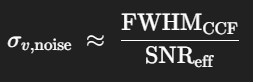   where  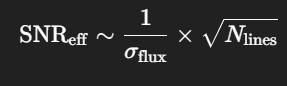

In [20]:
#  CALC approx RV error from flux noise estimate

snr_pix = 1.0 / sigma_flux      # SNR per pixel from earlier noise estimate
snr_eff = snr_pix * np.sqrt(6)   # 3 CaT effective lines

sigma_v_noise = fwhm_kms / snr_eff     # approximate RV error from flux noise
print(f"Approx RV error from flux noise: ± {sigma_v_noise:.3f} km/s (SNR_pix={snr_pix:.1f}, SNR_eff={snr_eff:.1f})")

Approx RV error from flux noise: ± 0.403 km/s (SNR_pix=111.0, SNR_eff=271.9)


In [21]:
# claculate instrument error
#  from ESO FLAMES User Manual  Wavelength solutions are stable to ~0.1–0.2 pixel   --  page 33 of user manual:  https://www.eso.org/sci/facilities/paranal/instruments/flames/doc/ESO-281173_V7_FLAMES_USER_MANUAL.pdf
# ' The flexures due to temperature variations measured in GIRAFFEinlong term tests amount to ⇠ 0.4pixels/Kalongandperpendicularto  dispersion, which translates into typical shifts of ⇠0.2pixel in the 12 hours night/day interval on the detector. ''

c_kms = 299792.458
dl = np.nanmedian(np.diff(lam_o))      # Å/pixel
lam0 = np.nanmedian(lam_o)             # Å
dv_pix = c_kms * dl / lam0             # km/s per pixel
inst_error = 0.2 * dv_pix              # if you adopt 0.2 pixel
print("dl =", dl, "Å/pix")
print("dv_pix =", dv_pix, "km/s per pix")
print("inst_error =", inst_error, "km/s")


dl = 0.05000052479772421 Å/pix
dv_pix = 1.7450237225645808 km/s per pix
inst_error = 0.3490047445129162 km/s


In [22]:
# ADD errors in quadrature =    sqrt( (gaussian fit error)^2 + (flux noise error)^2 + (instrument error)^2 )
#  instrument error floor (e.g., GIRAFFE ~0.2 km/s)
total_rv_error = np.sqrt(mu_err**2 + sigma_v_noise**2 + inst_error**2)
print(f"Total RV error (quadrature of fit, flux noise, instrument): ± {total_rv_error:.3f} km/s")

Total RV error (quadrature of fit, flux noise, instrument): ± 0.537 km/s


what we expect for the total error:  empirical repeatability from:   Battaglia et al. (2006), Walker et al. (2009), Koch et al. (2006), Simon & Geha (2007)   gives      ≲1 km/s stability for GIRAFFE CaT data

RV (grid-peak): 242.180 km/s   (limited by rvstep=1.745 km/s)
RV (3-pt parabola): 242.328 km/s   (sub-grid peak)
CCF FWHM: 109.58 km/s - describes width of CCF peak (full-width-at-half-maximum) - reflecting widths of lines in spectra
Tonry–Davis R: 4.68   (higher is better)
RV (Tonry–Davis error): ± 7.239 km/s


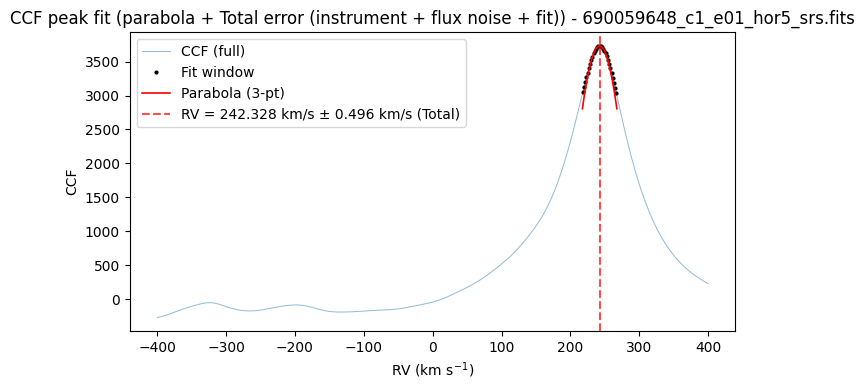

In [17]:
# --- 3-point parabola fit of the CCF peak for sub-grid RV  (3 point porobala better fit for the RV peak) ---

import numpy as np
import matplotlib.pyplot as plt

# 1) find grid peak
i0  = int(np.nanargmax(CC))
mu0 = RV[i0]   # grid peak RV, as a first guess for peak centre    [does the same as (best_rv = RV[peak_index]) line in above cell]

# 2) 3-point parabola around the peak (needs i0-1 and i0+1 to exist)
if i0 == 0 or i0 == len(CC) - 1:
    # can't do 3-point refinement at edge; fall back to grid peak
    rv_parab = mu0
    parab_ok = False
else:
    # Fit a parabola y = a x^2 + b x + c through the three points around the maximum
    x3 = RV[i0-1:i0+2]
    y3 = CC[i0-1:i0+2]
    a, b, c = np.polyfit(x3, y3, 2)

    # Vertex (sub-grid peak) of the parabola
    # NOTE: if a >= 0, it's not a concave-down peak; fall back to grid peak
    if np.isfinite(a) and (a < 0):
        rv_parab = -b / (2.0 * a)
        parab_ok = True
    else:
        rv_parab = mu0
        parab_ok = False

# 3) Estimate FWHM of the CCF peak (needed for Tonry–Davis error)
#    We'll measure it directly from the CCF around the peak:
cc_peak = CC[i0]
cc_base = np.nanmedian(CC)   # simple baseline estimate
half_level = cc_base + 0.5 * (cc_peak - cc_base)

# Find left crossing
ileft = i0
while ileft > 0 and CC[ileft] > half_level:
    ileft -= 1

# Find right crossing
iright = i0
while iright < len(CC)-1 and CC[iright] > half_level:
    iright += 1

# Interpolate to get more accurate half-maximum crossing RVs
def interp_cross(i1, i2, ylevel):
    # linear interpolate between points i1 and i2
    x1, x2 = RV[i1], RV[i2]
    y1, y2 = CC[i1], CC[i2]
    if not (np.isfinite(x1) and np.isfinite(x2) and np.isfinite(y1) and np.isfinite(y2)):
        return np.nan
    if y2 == y1:
        return 0.5*(x1+x2)
    return x1 + (ylevel - y1) * (x2 - x1) / (y2 - y1)

if ileft == 0 or iright == len(CC)-1:
    fwhm_kms = np.nan
else:
    rv_left  = interp_cross(ileft,  ileft+1,  half_level)
    rv_right = interp_cross(iright-1, iright, half_level)
    fwhm_kms = float(rv_right - rv_left) if np.isfinite(rv_left) and np.isfinite(rv_right) else np.nan

# Use the CCF peak height above baseline as "signal strength"
amp_peak = float(cc_peak - cc_base)  #  signal strength of the correlation peak (height above background)

# --- Tonry–Davis (1979) error on RV (uses FWHM and antisymmetric CCF noise) ---
# antisymmetric CCF noise; exclude a region around the peak
win_antisym = max(2.0 * (fwhm_kms if np.isfinite(fwhm_kms) else 25.0), 20.0)  # km/s
# Defines vel window around the CCF peak that will be excluded when measuring noise - BUT it will never be less than 20 km/s

# IMPORTANT: CC[::-1] only works if RV is perfectly symmetric/evenly sampled about 0.
# Safer: build A(v) = 0.5[CC(v) - CC(-v)] via interpolation on a symmetric RV grid.
RV = np.asarray(RV, dtype=float)
CC = np.asarray(CC, dtype=float)

mfin = np.isfinite(RV) & np.isfinite(CC)
rvv = RV[mfin]
ccv = CC[mfin]
if rvv[0] > rvv[-1]:
    rvv = rvv[::-1]
    ccv = ccv[::-1]

rv_sym = np.linspace(-min(abs(rvv.min()), abs(rvv.max())),
                      min(abs(rvv.min()), abs(rvv.max())),
                      rvv.size)

cc_pos = np.interp(rv_sym,  rvv, ccv, left=np.nan, right=np.nan)
cc_neg = np.interp(-rv_sym, rvv, ccv, left=np.nan, right=np.nan)

resid_antisym = 0.5 * (cc_pos - cc_neg)  # Compute antisymmetric component of the CCF
mask_noise = (rv_sym < rv_parab - win_antisym) | (rv_sym > rv_parab + win_antisym)  # Mask to select noise regions away from peak

if np.isfinite(resid_antisym[mask_noise]).sum() > 10:
    sigma_a = np.nanstd(resid_antisym[mask_noise])
else:
    sigma_a = np.nanstd(resid_antisym) if np.isfinite(resid_antisym).sum() > 10 else np.nan

if np.isfinite(sigma_a) and (sigma_a > 0) and np.isfinite(amp_peak) and (amp_peak > 0) and np.isfinite(fwhm_kms) and (fwhm_kms > 0):
    TD_R = amp_peak / (np.sqrt(2.0) * sigma_a)
    RV_td_err_kms = (3.0/8.0) * fwhm_kms / (1.0 + TD_R)
else:
    TD_R = np.nan
    RV_td_err_kms = np.nan
# --- end Tonry–Davis block ---

# 4) report
print(f"RV (grid-peak): {mu0:.3f} km/s   (limited by rvstep={rvstep:.3f} km/s)")
print(f"RV (3-pt parabola): {rv_parab:.3f} km/s   (sub-grid peak)")
print(f"CCF FWHM: {fwhm_kms:.2f} km/s - describes width of CCF peak (full-width-at-half-maximum) - reflecting widths of lines in spectra")
print(f"Tonry–Davis R: {TD_R:.2f}   (higher is better)")
print(f"RV (Tonry–Davis error): ± {RV_td_err_kms:.3f} km/s")

# 5) plot zoom with "fit" (keep your plotting style intact)
# pick a window around the peak for display
guess_win = 25.0  # km/s display window; adjust
sel = (RV > rv_parab - guess_win) & (RV < rv_parab + guess_win)
x = RV[sel]
y = CC[sel]

# Parabola curve for plotting (use coefficients from 3-point fit when available)
xx = np.linspace(rv_parab - guess_win, rv_parab + guess_win, 800)

if parab_ok:
    yy = a*xx**2 + b*xx + c
else:
    # fallback: just connect points if parabola wasn't valid
    yy = np.interp(xx, RV, CC)

plt.figure(figsize=(7,4))
plt.plot(RV, CC, lw=0.7, alpha=0.5, label="CCF (full)")
plt.plot(x, y, 'k.', ms=4, label="Fit window")
plt.plot(xx, yy, 'r-', lw=1.2, label="Parabola (3-pt)")
plt.axvline(rv_parab, color='r', ls='--', alpha=0.7,
            label=f"RV = {rv_parab:.3f} km/s ± {total_rv_error:.3f} km/s (Total)")
plt.xlabel("RV (km s$^{-1}$)"); plt.ylabel("CCF")
plt.title(f"CCF peak fit (parabola + Total error (instrument + flux noise + fit)) - {fn}")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
import pandas as pd


spectral_lines = pd.DataFrame([
{"Label": "Ca II K",     "Wavelength": 3933.66},
    {"Label": "Ca II H",     "Wavelength": 3968.47},
    {"Label": "Ca I 4227",   "Wavelength": 4226.73},
    {"Label": "Fe I 4046",   "Wavelength": 4045.81},
    {"Label": "Fe I 4384",   "Wavelength": 4383.55},
    {"Label": "Fe I 5270",   "Wavelength": 5270.36},
    {"Label": "Fe I 5328",   "Wavelength": 5328.04},
    {"Label": "Mg I b1",     "Wavelength": 5167.32},
    {"Label": "Mg I b2",     "Wavelength": 5172.68},
    {"Label": "Mg I b3",     "Wavelength": 5183.60},
    {"Label": "He I 4471",   "Wavelength": 4471.5},
    {"Label": "H γ",         "Wavelength": 4340.5},
    {"Label": "H β",         "Wavelength": 4861.3},
    {"Label": "Na I D1",     "Wavelength": 5890.0},
    {"Label": "Na I D2",     "Wavelength": 5896.0},
    {"Label": "H α",         "Wavelength": 6562.8},
    {"Label": "Ca II 8498",  "Wavelength": 8498.02},
    {"Label": "Ca II 8542",  "Wavelength": 8542.09},
    {"Label": "Ca II 8662",  "Wavelength": 8662.14}
])

spectral_lines

,Label,Wavelength
0,Ca II K,3933.66
1,Ca II H,3968.47
2,Ca I 4227,4226.73
3,Fe I 4046,4045.81
4,Fe I 4384,4383.55
5,Fe I 5270,5270.36
6,Fe I 5328,5328.04
7,Mg I b1,5167.32
8,Mg I b2,5172.68
9,Mg I b3,5183.60


: 

: 

: 

: 

: 

: 